## Week 6 Homework

---

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to sample from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*


In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

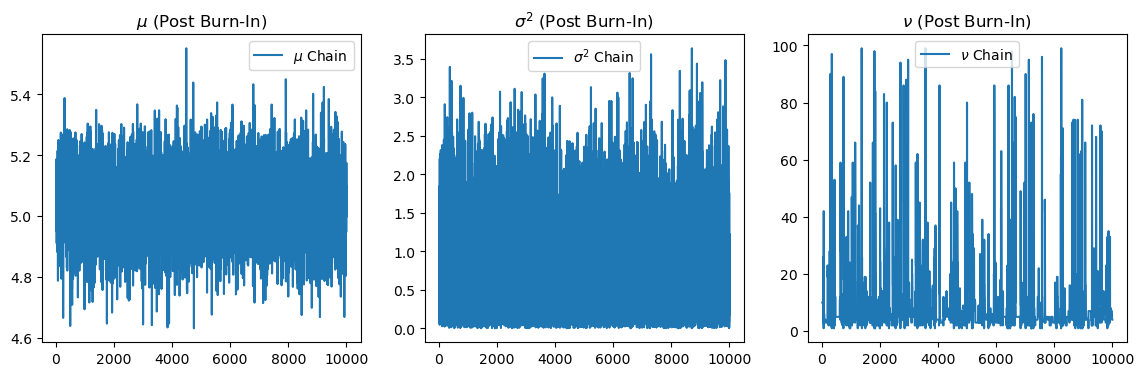

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Hyperparameters
num_samples = 10000
n = 100  # Sample size
mu_0 = 0
tau_0 = 1
sigma_0 = 1
nu_values = np.arange(1, 101)

# Simulated Data (true values)
np.random.seed(365)
true_mu = 5
true_sigma2 = 2
true_nu = 10
data = true_mu + np.sqrt(true_sigma2) * np.random.standard_t(true_nu, size=n)

# Initialize parameters
mu = np.mean(data)
sigma2 = np.var(data)
nu = np.random.choice(nu_values)

# Storage for samples
samples = {"mu": [], "sigma2": [], "nu": []}

# Metropolis-Hastings update for ν
def metropolis_hastings_nu(nu_current, mu, sigma2, data):
    proposal = np.random.choice(nu_values)
    log_accept_ratio = (
        np.sum(stats.t.logpdf(data, df=proposal, loc=mu, scale=np.sqrt(sigma2))) -
        np.sum(stats.t.logpdf(data, df=nu_current, loc=mu, scale=np.sqrt(sigma2)))
    )
    if np.log(np.random.rand()) < log_accept_ratio:
        return proposal
    return nu_current

# Gibbs Sampling
for _ in range(num_samples):
    # Sample mu given sigma2
    mu_n = (tau_0 * mu_0 + n * np.mean(data)) / (tau_0 + n)
    sigma_n2 = sigma2 / (tau_0 + n)
    mu = np.random.normal(mu_n, np.sqrt(sigma_n2))
    
    # Sample sigma2 given mu (Half-Normal)
    sigma2 = stats.halfnorm.rvs(scale=sigma_0)  # Corrected half-normal sampling
    
    # Sample nu using Metropolis-Hastings
    nu = metropolis_hastings_nu(nu, mu, sigma2, data)
    
    # Store samples
    samples["mu"].append(mu)
    samples["sigma2"].append(sigma2)
    samples["nu"].append(nu)

# Plot Trace Plots
burn_in = 20
demo_2 = len(samples["mu"])  # Ensure indexing is correct

fig, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0].set_title(r"$\mu$ (Post Burn-In)")
ax[1].set_title(r"$\sigma^2$ (Post Burn-In)")
ax[2].set_title(r"$\nu$ (Post Burn-In)")

ax[0].plot(np.arange(burn_in, demo_2, dtype=int), samples["mu"][burn_in:demo_2], label="$\\mu$ Chain ")
ax[1].plot(np.arange(burn_in, demo_2, dtype=int), samples["sigma2"][burn_in:demo_2], label="$\\sigma^2$ Chain ")
ax[2].plot(np.arange(burn_in, demo_2, dtype=int), samples["nu"][burn_in:demo_2], label="$\\nu$ Chain ")

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.show()


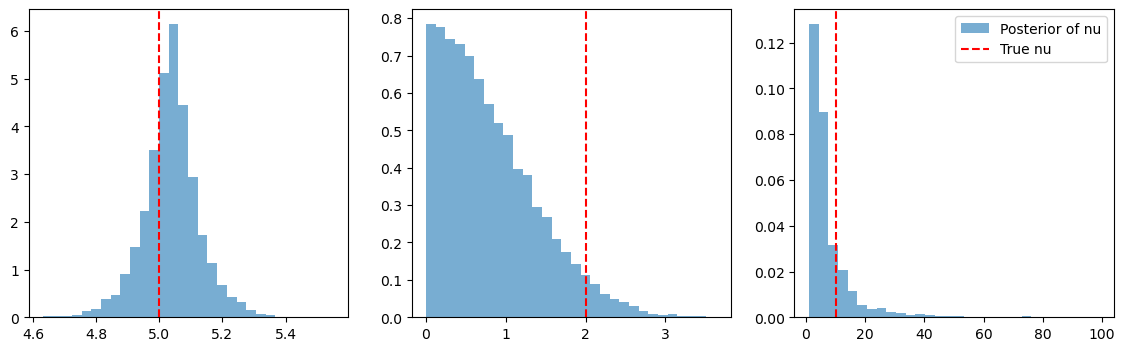

In [3]:
fig, ax = plt.subplots(1,3,figsize=(14, 4))

ax[0].hist(samples["mu"], bins=30, density=True, alpha=0.6, label="Posterior of mu")
ax[1].hist(samples["sigma2"], bins=30, density=True, alpha=0.6, label="Posterior of sigma2")
ax[2].hist(samples["nu"], bins=30, density=True, alpha=0.6, label="Posterior of nu")

ax[0].axvline(true_mu, color='r', linestyle='dashed', label="True mu")
ax[1].axvline(true_sigma2, color='r', linestyle='dashed', label="True sigma2")
ax[2].axvline(true_nu, color='r', linestyle='dashed', label="True nu")

plt.legend()
plt.show()


### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*



In [4]:
import pymc 
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Define different sample sizes
sample_sizes = [10, 50, 100, 500]

# True parameter values
true_mu = 5
true_sigma = 2
true_nu = 10

# Generate synthetic data for different sample sizes
np.random.seed(365)
data_samples = {
    n: true_mu + true_sigma * np.random.standard_t(true_nu, size=n)
    for n in sample_sizes
}

print(len(data_samples))

4


In [5]:
# Store results
trace_results = {}

# Iterate over different sample sizes
for n, data in data_samples.items():
    print(f"Running inference for sample size: {n}")

    with pymc.Model() as model:
        # Priors
        mu = pymc.Normal("mu", mu=0, sigma=10)
        sigma = pymc.HalfNormal("sigma", sigma=10)
        nu = pymc.DiscreteUniform("nu", lower=1, upper=100)

        # Likelihood
        obs = pymc.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=data)

        # Sampling
        trace = pymc.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.9)
    
    # Store trace results
    trace_results[n] = trace



Running inference for sample size: 10


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Running inference for sample size: 50


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Running inference for sample size: 100


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running inference for sample size: 500


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


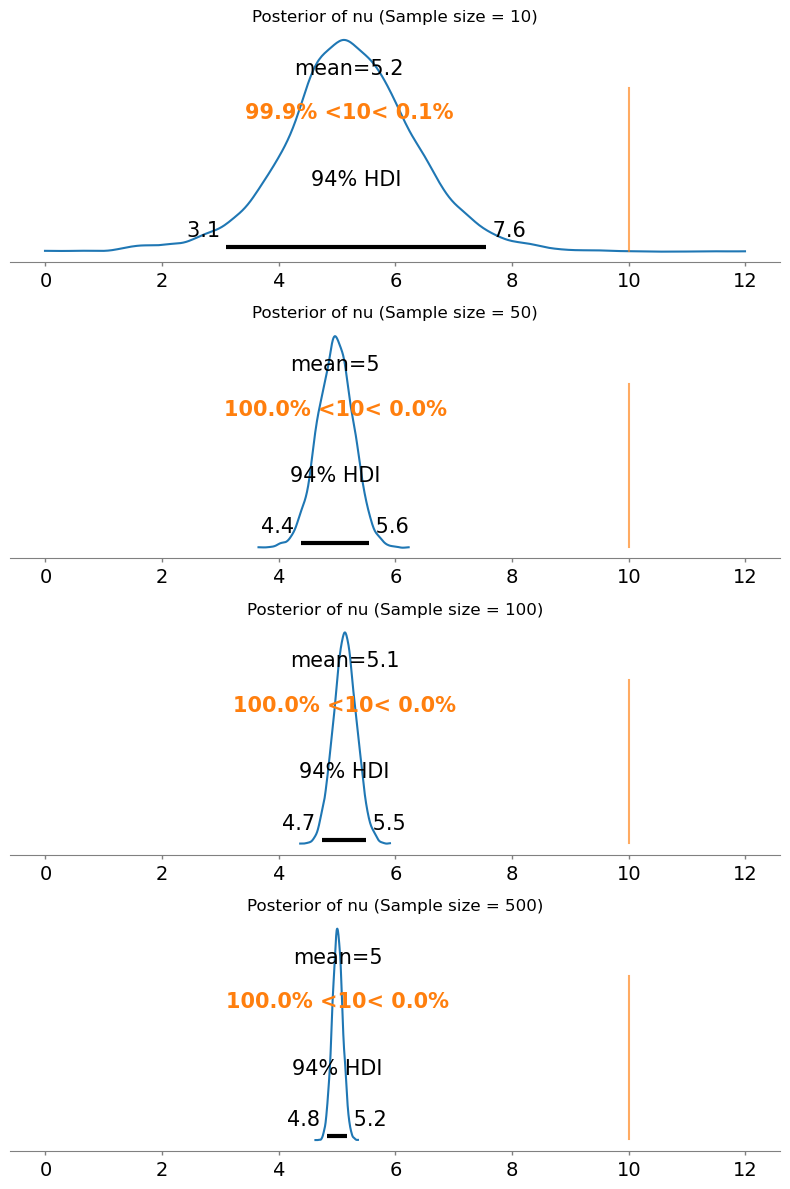

In [6]:
# Plot results for nu across different sample sizes
fig, axes = plt.subplots(len(sample_sizes), 1, figsize=(8, 12), sharex=True)

for i, n in enumerate(sample_sizes):
    ax = axes[i]
    az.plot_posterior(trace_results[n], ax=ax, ref_val=true_nu)
    ax.set_title(f"Posterior of nu (Sample size = {n})")

plt.tight_layout()
plt.show()

Interpretation: The Highest Density Interval (HDI) represents the credible interval in Bayesian inference, showing where the most probable values of a parameter lie. The HDI plots shown have the credible interval getting smaller while the sample size gets large as expected. Since for small sample size, the posterior for nu are larger as there are more uncertainty and the posterior of nu with larger sample size is more concentrated. 

### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$

### First writing out the explicit format of $p(\tau_i)$ and $p(y_i|\tau_i)$

### **Explicit Format of $p(\tau_i)$ (Gamma Distribution)**
The prior follows a **Gamma distribution**:

$$
p(\tau_i) = \frac{\beta^\alpha}{\Gamma(\alpha)} \tau_i^{\alpha - 1} e^{-\beta \tau_i}, \quad \tau_i > 0
$$

Given that:
- $\alpha = \frac{\nu}{2}$ (shape parameter)
- $\beta = \frac{\nu}{2} $ (rate parameter)

we substitute these values:

$$
p(\tau_i) = \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2} - 1} e^{-\frac{\nu}{2} \tau_i}, \quad \tau_i > 0.
$$

---

### **Explicit Format of \( p(y_i | \tau_i) \) (Normal Distribution with Precision)**
The likelihood of \( y_i \) given \( \tau_i \) follows a **Normal distribution**:

$$
p(y_i | \tau_i) = \mathcal{N}(y_i | 0, \tau_i^{-1})
$$

This means:

$$
p(y_i | \tau_i) = \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2}.
$$

where:
- The mean is 0.
- The variance is $\tau_i^{-1}$, meaning precision (inverse variance) is $ \tau_i $.

### Then subsitute into the expression: 
We compute:

$$
\int p(y_i|\tau_i) p(\tau_i)  d\tau_i
$$

Substituting the given distributions:

$$
\int \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2} \cdot \frac {\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1} e^{-\frac{\nu}{2} \tau_i} d\tau_i.
$$

Rearrange terms:

$$
\int \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \sqrt{\frac{\tau_i}{2\pi}} \tau_i^{\frac{\nu}{2}-1} e^{-\frac{1}{2} \tau_i (y_i^2 + \nu)} d\tau_i.
$$

Factor out constants:

$$
\frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \sqrt{\frac{1}{2\pi}} \int \tau_i^{\frac{\nu}{2} - \frac{1}{2}} e^{-\frac{1}{2} \tau_i (y_i^2 + \nu)} d\tau_i.
$$

---

The integral:

$$
\int \tau_i^{\frac{\nu}{2} - \frac{1}{2}} e^{-\lambda \tau_i} d\tau_i
$$

is the **Gamma function normalization** if matched to the Gamma density form:

$$
\int x^{a-1} e^{-\lambda x} dx = \frac{\Gamma(a)}{\lambda^a}.
$$

Comparing terms:
- \( a = \frac{\nu}{2} + \frac{1}{2} \),
- \( \lambda = \frac{1}{2}(y_i^2 + \nu) \).

Thus:

$$
\int \tau_i^{\frac{\nu}{2} - \frac{1}{2}} e^{-\frac{1}{2} \tau_i (y_i^2 + \nu)} d\tau_i = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\left(\frac{1}{2} (y_i^2 + \nu)\right)^{\frac{\nu+1}{2}}}.
$$

---

Substituting this back:

$$
p(y_i) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)} \cdot \frac{1}{\sqrt{\nu \pi}} \left(1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}.
$$

This is precisely the **Student's t-distribution density function**:

$$
y_i \sim t_\nu(0,1).
$$

---

### Interpretation
1. **Posterior Predictive Behavior**  
   - This derivation shows that marginalizing over the latent precision parameter $ \tau_i $ results in a Student’s t-distribution.
   - The t-distribution naturally arises when we integrate out uncertainty in the variance parameter.
  
2. **Why This is Analogous to the Posterior Predictive Distribution**  
   - In Bayesian inference, the posterior predictive distribution** accounts for **both parameter uncertainty and likelihood variance.
   - Here, we integrate over uncertainty in $ \tau_i$ , leading to the t-distribution, which has heavier tails than the normal, modeling uncertainty more robustly.

Therefore,
$$
p(y_i) = t_\nu(0,1).
$$

This derivation shows that the posterior predictive distribution follows a Student’s t-distribution, which is robust and accounts for **uncertainty in the precision parameter $ \tau_i $.

